<a href="https://colab.research.google.com/github/MichaelArthur224/Project-2/blob/main/Stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Coding Dojo/ML Week 3/healthcare-dataset-stroke-data.csv')
df1 = df.copy()
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
#Check class balance
df['stroke'].value_counts(normalize=True)


0    0.951272
1    0.048728
Name: stroke, dtype: float64

In [4]:
df.shape[0]

5110

In [5]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

##Data Cleaning

In [6]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
#Filled missing bmi with average
#df.fillna({"bmi":df['bmi'].mean().round(1)}, inplace=True)
#df['bmi'].head()

In [9]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [10]:
#Since there is only 1 other gender I will change it to male to be easier to work with there is also less males than females in the data set
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [11]:
df['gender'] = df['gender'].replace('Other', 'Male')
df.loc[df['gender']=='Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [12]:
df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1})

In [13]:
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [14]:
replacement_dictionary = {'never smoked':0, 'Unknown':1, 'formerly smoked':2, 'smokes':3}
df['smoking_status'].replace(replacement_dictionary, inplace=True)

In [15]:
#As of now I have not decided to drop any columns. I want to develop a plan and see what will be used and what will not be used.

##Exploratory

From your data analysis, create two visuals that demonstrate key findings of interest to a stakeholder. These visuals should be reporting quality. Be sure to explain the finding associated with each visual. (NO histograms, boxplots, or correlation plots)

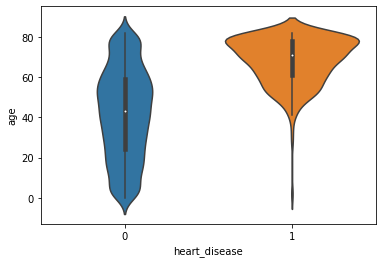

In [16]:
sns.violinplot(data=df, x='heart_disease', y='age')

heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
You can see that people of older age have heart disease, meanwhile the amount of younger people without heart disease is greater

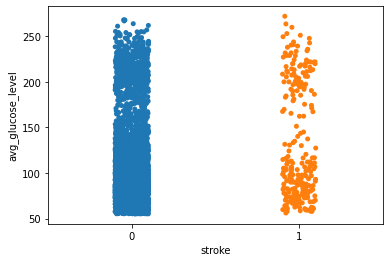

In [17]:
sns.stripplot(data=df, x='stroke', y='avg_glucose_level')

stroke: 1 if the patient had a stroke or 0 if not
The amount of people with a glucose level around 150 seem to have the least amount of strokes

When viewing these graphs you can see what age group and what glucose level we need to research more in depth

In [18]:
df['age'].mean()

43.226614481409

##Pre Process

In [73]:
#loop for creating history plots
def plot_history(history):
  metrics = history.history.keys()
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

In [19]:
X = df.drop(columns=['stroke'])
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [20]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [21]:
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [22]:
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [23]:
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [24]:
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f03f8da1970>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f03f8da1070>

In [25]:
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

Model Pipeline

In [59]:
reg = LogisticRegression()
reg_pipe = make_pipeline(preprocessor, reg)
reg_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f03f8da1970>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncode

In [57]:
reg_pipe.fit(X_train, y_train)
training_predictions = reg_pipe.predict(X_train)
test_predictions = reg_pipe.predict(X_test)

##Imbalance

In [31]:
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [61]:
under_sampler = RandomUnderSampler()
under_sample_pipe = make_sampler_pipeline(scaler, under_sampler)
X_train_under, y_train_under = under_sample_pipe.fit_resample(X_train_processed, y_train)

##Tune

In [33]:
#create and visualize our parameter grid
param_grid = {'max_depth': [1,2,3],
              'min_samples_leaf': [3,15,20],
              'min_samples_split': [2, 10, 100]}

pd.DataFrame(param_grid).T

,0,1,2
max_depth,1,2,3
min_samples_leaf,3,15,20
min_samples_split,2,10,100


In [34]:
model = DecisionTreeClassifier()

param_grid = {'max_depth': [1,2,3],
              'min_samples_leaf': [3,15,20],
              'min_samples_split': [2, 10, 100]}

In [35]:
dt_grid_search = GridSearchCV(model, param_grid)
dt_grid_search.fit(X_train_under, y_train_under)
y_pred = dt_grid_search.predict(X_test_processed)

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.66      0.79      1198
           1       0.14      0.85      0.25        80

    accuracy                           0.67      1278
   macro avg       0.56      0.76      0.52      1278
weighted avg       0.93      0.67      0.76      1278



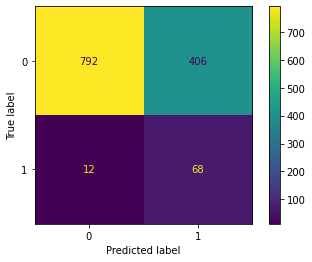

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

##Decision Tree 

In [67]:
from sklearn.tree import DecisionTreeClassifier
#starting at 2
dec_tree = DecisionTreeClassifier(random_state = 42, max_depth=5)

In [68]:
dec_tree.fit(X_train_under, y_train_under)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [69]:
dec_pred = dec_tree.predict(X_test_processed)

In [70]:
train_score = dec_tree.score(X_train_under, y_train_under)
test_score = dec_tree.score(X_test_processed, y_test)
print(train_score)
print(test_score)

0.8550295857988166
0.6369327073552425


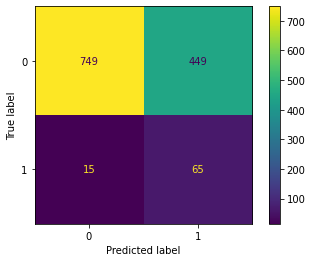

In [71]:
ConfusionMatrixDisplay.from_predictions(y_test, dec_pred)

In [43]:
print(classification_report(y_test, dec_pred))

              precision    recall  f1-score   support

           0       0.98      0.67      0.80      1198
           1       0.15      0.84      0.25        80

    accuracy                           0.68      1278
   macro avg       0.56      0.75      0.52      1278
weighted avg       0.93      0.68      0.76      1278



##KNN With PCA

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

In [45]:
knn = KNeighborsClassifier(n_neighbors=3)

In [46]:
scaled_df_pca = scaler.fit_transform(X_train_under, y_train_under)
pca = PCA(n_components=2)
pca.fit(scaled_df_pca)

PCA(n_components=2)

In [47]:
knn_pipe_pca = make_pipeline (scaler, PCA(2), KNeighborsClassifier())
knn_pipe_pca.fit(X_train_under, y_train_under)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [48]:
preds_pca = knn_pipe_pca.predict(X_test_processed)
preds_pca

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
acc_score_pca = knn_pipe_pca.score(X_test_processed, y_test)
acc_score_pca

0.7777777777777778

In [50]:
pipe_param_grid = {'kneighborsclassifier__n_neighbors': range(1,10),'kneighborsclassifier__p': range(1,5),'kneighborsclassifier__weights': ['distance','uniform']}

In [51]:
knn_pipe_gs = GridSearchCV(knn_pipe_pca, pipe_param_grid)
knn_pipe_gs.fit(X_train_under, y_train_under)
best_pipe = knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_pipe.score(X_test_processed, y_test)}')

Accuracy of best KNN model is: 0.7777777777777778


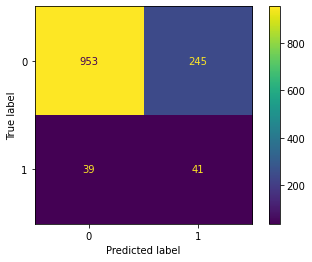

In [52]:
ConfusionMatrixDisplay.from_predictions(y_test, preds_pca)

In [53]:
print(classification_report(y_test, preds_pca))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1198
           1       0.14      0.51      0.22        80

    accuracy                           0.78      1278
   macro avg       0.55      0.65      0.55      1278
weighted avg       0.91      0.78      0.83      1278



##Evaluate

In [54]:
#KNN with PCA
acc_score_pca

0.7777777777777778

In [72]:
#Dec Tree
test_score

0.6369327073552425

After looking at the models and reports I came to the conclusion that the dec tree is the best option. This is because it predicts more people will have a stroke. I choose this because it is better to be safe than sorry. We can look into more patients and help them improve thier health. Even if they were to not have a stroke we can potentially help and improve their overall health and get them closer away from a stroke.